# COVID-19 growth analysis
> Visualizations of the growth of COVID-19. Updated Hourly.

- comments: true
- author: Thomas Wiecki
- categories: [growth]
- image: images/covid-growth.png
- permalink: /growth-analysis/

In [1]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

In [2]:
# hide
!if cd COVID-19; then git pull; else git clone https://github.com/CSSEGISandData/COVID-19.git COVID-19; fi

remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 191 (delta 96), reused 103 (delta 96), pack-reused 88
Receiving objects: 100% (191/191), 64.29 KiB | 7.14 MiB/s, done.
Resolving deltas: 100% (96/96), completed with 14 local objects.
From https://github.com/CSSEGISandData/COVID-19
   8556d4e..4b81417  master     -> origin/master
   b01210b..b084ff2  web-data   -> origin/web-data
Updating 8556d4e..4b81417
Fast-forward
 .../csse_covid_19_daily_reports/03-12-2020.csv     | 219 ++++++
 .../time_series_19-covid-Confirmed.csv             | 812 +++++++++++----------
 .../time_series_19-covid-Deaths.csv                | 812 +++++++++++----------
 .../time_series_19-covid-Recovered.csv             | 812 +++++++++++----------
 4 files changed, 1440 insertions(+), 1215 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/03-12-2020.csv


In [3]:
#hide
def load_timeseries(name):
    df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-{}.csv'.format(name), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'], parse_dates=True)
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[(df.country == 'China') & (df.state =='Hong Kong'), 'country'] = 'Hong Kong'
    df.loc[(df.country == 'China') & (df.state =='Hong Kong'), 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, df.loc[~df.state.isna()].groupby(['country', 'date', 'type']).sum().rename(index=lambda x: x+' (total)', level=0).reset_index(level=['country', 'type'])])
    return df

df = pd.concat([load_timeseries('Confirmed'),
           load_timeseries('Recovered'),
           load_timeseries('Deaths')])

df.head(10)

,country,state,type,cases
date,,,,
2020-01-22,Thailand,NaN,confirmed,2
2020-01-23,Thailand,NaN,confirmed,3
2020-01-24,Thailand,NaN,confirmed,5
2020-01-25,Thailand,NaN,confirmed,7
2020-01-26,Thailand,NaN,confirmed,8
2020-01-27,Thailand,NaN,confirmed,8
2020-01-28,Thailand,NaN,confirmed,14
2020-01-29,Thailand,NaN,confirmed,14
2020-01-30,Thailand,NaN,confirmed,14


In [4]:
#hide
# Country names seem to change quite a bit
df.country.unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland',
       'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland',
       'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal',
       'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Hungary',
       'Liechtenstein', 'Poland', 'Tunisia', 'Bosnia and Herzegovina',
       'Slovenia', 'South Africa', 'Bhutan', 'Cameroon', 'Colo

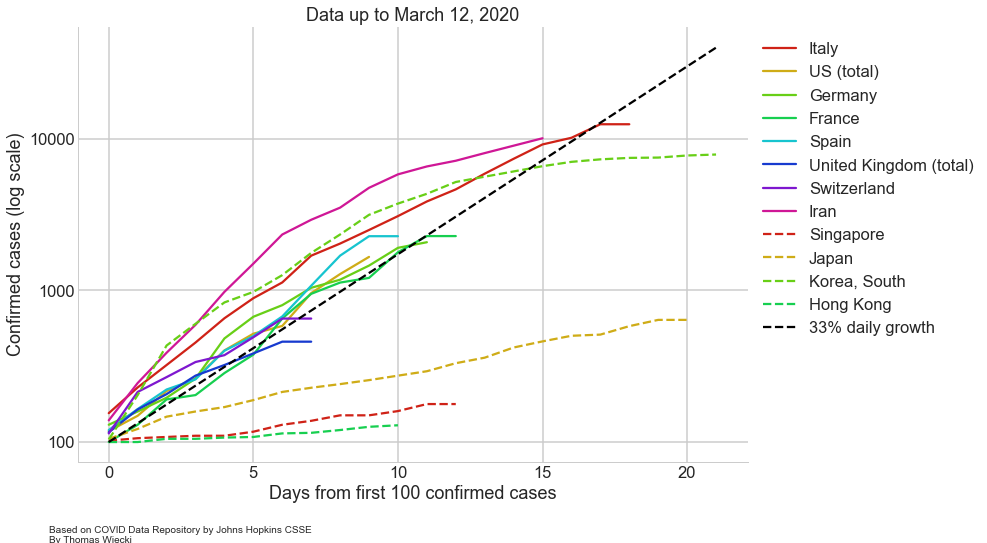

In [5]:
# hide_input

def plot_confirmed(countries, min_cases=100, ls='-'):
    for country in countries:
        (df.loc[(df.country == country) & (df.type == 'confirmed') & (df.cases >= min_cases)]
         .cases
         .reset_index()['cases']
         .plot(label=country, ls=ls)
        )

        
sns.set_palette(sns.hls_palette(8, l=.45, s=.8)) # 8 countries max
fig, ax = plt.subplots(figsize=(12, 8))

countries = ['Italy', 'US (total)', 'Germany', 'France', 'Spain', 'United Kingdom (total)', 
             'Switzerland', 'Iran']
plot_confirmed(countries)

asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong'] 
plot_confirmed(asian_countries, ls='--')


x = np.linspace(0, plt.xlim()[1] - 1)
plt.plot(x, 100 * (1.33) ** x, ls='--', color='k', label='33% daily growth')

plt.yscale('log');
plt.title('Data up to {}'.format(df.index.max().strftime('%B %d, %Y')))
plt.xlabel('Days from first 100 confirmed cases')
plt.ylabel('Confirmed cases (log scale)')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(bbox_to_anchor=(1.0, 1.0))
sns.despine()
plt.annotate('Based on COVID Data Repository by Johns Hopkins CSSE\nBy Thomas Wiecki', 
             (0.05, 0.0), xycoords='figure fraction', fontsize=10);

In [7]:
#hide
fig.savefig('../images/covid-growth.png')

Updated hourly by [GitHub Actions](https://github.com/features/actions).

This visualization was made by [Thomas Wiecki](https://twitter.com/twiecki)[^1].

[^1]:  Data sourced from ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19) and recreates the (pay-walled) plot in the [Financial Times]( https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth.ipynb).